In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, multilabel_confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
from skimage.exposure import equalize_hist, equalize_adapthist

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate, Add, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing import dataset_utils
from keras.preprocessing import image_dataset

!pip install tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 31.3 MB/s 


In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Autotune Value = {AUTOTUNE}")

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Autotune Value = -1


In [ ]:
hnm_file_format = '/content/drive/MyDrive/Temporary/CS25_Project/HnM_{}.parquet'
hnm_img_format = '/content/drive/MyDrive/Temporary/CS25_Project/images/HnM/{}'

cna_file_format = '/content/drive/MyDrive/Temporary/CS25_Project/CnA_{}.parquet'
cna_img_resized = '/content/drive/MyDrive/Temporary/CS25_Project/images_test_resized/CnA_'


In [ ]:
# folder names
hnm_img_final = '/content/drive/MyDrive/Temporary/CS25_Project/images_final/HnM/'
hnm_img_final_top = '/content/drive/MyDrive/Temporary/CS25_Project/images_final'

hnm_img_resized = '/content/drive/MyDrive/Temporary/CS25_Project/images_resized/HnM/'
hnm_img_resized_top = '/content/drive/MyDrive/Temporary/CS25_Project/images_resized'

In [ ]:
model_wts_path = '/content/drive/MyDrive/Temporary/CS25_Project/'
model_hist_path = '/content/drive/MyDrive/Temporary/CS25_Project/'

In [ ]:
## load the data frame
df = pd.read_parquet(hnm_file_format.format('Final_Input_Df'))
df['Category_Name'] = df['Category_Name'].astype('category')
df['Category_Name_Code'] = df['Category_Name'].cat.codes

In [ ]:
# sort by the code since thats how flow from directory would work
df = df.sort_values(by='Code')
df.head()

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Category_Name_Code
9842,0107727001,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9844,0107727002,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9839,0107727021,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9832,0107727061,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23
9837,0107727062,Bademantel aus Leinen,.jpg,18.0,Women,Nachtwäsche,Women_Nachtwäsche,23


In [ ]:
y_train = df['Category_Name_Code'].values
nr_labels = len(np.unique(y_train))

In [ ]:
df['image_paths'] = df.apply(lambda row: f"{hnm_img_resized}{row['Code']}{row['Img_Ext']}", axis=1)

In [ ]:
input_shape = (224, 224, 3)

In [ ]:
# def get_img_generator(
#     df,
#     image_dir, 
#     val_split=0.0,
#     shuffle=True, 
#     batch_size=8, 
#     seed=1, 
#     preprocess_func=None,
#     input_shape=(224, 224, 3),
#     augment_params=None
# ):
#     """
#     Return generator for training set, normalizing using batch
#     statistics.

#     Args:
#       df (dataframe): dataframe specifying training data.
#       image_dir (str): directory where image files are held.
#       x_col (str): name of column in df that holds filenames.
#       y_cols (list): list of strings that hold y labels for images.
#       val_split (float): %age split for validation base (if required)
#       batch_size (int): images per batch to be fed into model during training.
#       seed (int): random seed.
#       preprocess_func (str): name of the function to call for preprocessing inputs
#       input_shape (tuple): tuple of 3 ints with expected shape of img tensors
#     Returns:
#         generator (DataFrameIterator): iterator over preprocessed image data / labels, training subset
#         val_generator (DataFrameIterator): iterator as above, validation subset; Only if val_split > 0
#     """
#     print("Creating generator...") 
#     if augment_params is not None:
#         image_generator = ImageDataGenerator(
#             samplewise_center=True,
#             samplewise_std_normalization= True,
#             preprocessing_function = eval(preprocess_func) if preprocess_func is not None else None,
#             validation_split = val_split,
#             **augment_params
#         )
#     else:
#         image_generator = ImageDataGenerator(
#             samplewise_center=True,
#             samplewise_std_normalization= True,
#             preprocessing_function = eval(preprocess_func) if preprocess_func is not None else None,
#             validation_split = val_split,
#         )

    
#     # flow from directory with specified batch size
#     # and target image size
#     generator = image_generator.flow_from_dataframe(
#         dataframe=df,
#         directory=image_dir,
#         x_col='filename',
#         y_col='Category_Name',
#         class_mode="sparse",
#         batch_size=batch_size,
#         shuffle=shuffle,
#         seed=seed,
#         subset='training',
#     )
    
#     if val_split > 0:
#         val_generator = image_generator.flow_from_dataframe(
#             dataframe=df,
#             directory=image_dir,
#             x_col='filename',
#             y_col='Category_Name',
#             class_mode="sparse",
#             batch_size=batch_size,
#             shuffle=shuffle,
#             seed=seed,
#             subset='validation',
#         )
#         return generator, val_generator

#     return generator

In [ ]:
img_shape = (224, 224, 3)
batch_size = 128

In [ ]:
# def ds_preprocess(ds, model_params):

#     if model_params.get('equalize', False):
#         if model_params.get('concat', False):
#             if model_params.get('input_filters', True): # handle extra complexity that x has input_masks also
#                 ds = ds.map(lambda x, y: ((x[0], tfa.image.equalize(x[0]), x[1]), y), num_parallel_calls=AUTOTUNE)
#             else:
#                 ds = ds.map(lambda x, y: ((x, tfa.image.equalize(x)), y), num_parallel_calls=AUTOTUNE)
#         else:
#             if model_params.get('input_filters', True): # handle extra complexity that x has input_masks also
#                 ds = ds.map(lambda x, y: ((tfa.image.equalize(x[0]), x[1]), y), num_parallel_calls=AUTOTUNE)
#             else:
#                 ds = ds.map(lambda x, y: (tfa.image.equalize(x), y), num_parallel_calls=AUTOTUNE)

#     # preprocess train and test sets if required
#     if model_params.get('preprocess', False):
#         if model_params.get('concat', False):
#             if model_params.get('input_filters', True): # handle extra complexity that x has input_masks also
#                 ds = ds.map(
#                     lambda x, y: (
#                         (
#                             eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[0]),
#                             eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[1]),
#                             x[2]
#                         ),
#                         y
#                         ),
#                         num_parallel_calls=AUTOTUNE
#                         )
#             else:
#                 ds = ds.map(
#                     lambda x, y: (
#                         (
#                             eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[0]),
#                             eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[1]),
#                         ),
#                         y
#                         ),
#                         num_parallel_calls=AUTOTUNE
#                         )
#         else:
#             if model_params.get('input_filters', True): # handle extra complexity that x has input_masks also
#                 ds = ds.map(lambda x, y: ( (eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[0]), x[1]), y ), num_parallel_calls=AUTOTUNE)
#             else:
#                 ds = ds.map(lambda x, y: ( eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x), y ), num_parallel_calls=AUTOTUNE)

#     return ds


In [ ]:
def generate_datasets(model_params, img_paths, labels = None, product_filters = None, filter_values = None, seed=25, batch_size=batch_size, 
                    image_size=img_shape[:2], num_channels=3, interpolation='bilinear', crop_to_aspect_ratio=False,
                    shuffle=True):
    """
        Sub-function to return a data set given a list of image paths and associated labels + addl information
        
        :param image_paths: paths to images
        :param labels: list of associated labels for each img
        :param cat_inputs: np array with cat_inputs for each img
        
        length of all inputs should be same as nr of images in directory
        
    """

    # generate dataset
    path_ds = tf.data.Dataset.from_tensor_slices(img_paths)
    args = (image_size, num_channels, interpolation, crop_to_aspect_ratio)
    img_ds = path_ds.map(
      lambda x: image_dataset.load_image(x, *args), num_parallel_calls=tf.data.AUTOTUNE
    )

    if model_params.get('concat', False):
        # concatenation of equalized images, load equalized images separately
        img_eq_ds = img_ds.map(lambda x: tfa.image.equalize(x), num_parallel_calls=AUTOTUNE)
        img_ds = tf.data.Dataset.zip((img_ds, img_eq_ds))
    elif model_params.get('equalize', False):
        # equalize the source image
        img_ds = img_ds.map(lambda x: tfa.image.equalize(x), num_parallel_calls=AUTOTUNE)

    # prod_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(product_filters))
    if labels is None:
        prod_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(np.concatenate(product_filters).reshape(-1, 20)))

        filt_ds = []
        for i, size in enumerate(out_size):
            vals = np.concatenate(filter_values[:, i]).reshape(-1, size)
            filt_ds.append(
                tf.data.Dataset.from_tensor_slices(vals)
            )

        # filt_ds = tuple(tf.data.Dataset.from_tensor_slices(tf.ragged.constant(f)) for f in filter_values)
        filt_ds = tf.data.Dataset.zip(tuple(f for f in filt_ds))

        inputs_ds = tf.data.Dataset.zip((img_ds, prod_ds))
        img_ds = tf.data.Dataset.zip((inputs_ds, filt_ds))
    else:
        labels_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(labels))

        img_ds = tf.data.Dataset.zip((img_ds, labels_ds))

    
    if shuffle:
        img_ds = img_ds.shuffle(buffer_size=batch_size * 8, seed=seed)
    img_ds = img_ds.batch(batch_size)
    return img_ds
    

In [ ]:
for inputs, outputs in images_val_f.take(1):
    break

In [ ]:
len(inputs[1])

64

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2_eq (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                              

In [ ]:
# separating a test set
df_train, df_test = train_test_split(df, train_size=0.9, random_state=25)

In [ ]:
# keeping train and validation separate
df_train, df_val = train_test_split(df_train, train_size=0.8, random_state=25)

In [ ]:
# random_seed = 25

# images_train = image_dataset_from_directory(
#     hnm_img_resized_top,
#     labels = list(y_train),
#     subset = 'training',
#     validation_split = 0.2,
#     seed = random_seed,
#     batch_size=256,
#     image_size=input_shape[:2]
# )

# images_val = image_dataset_from_directory(
#     hnm_img_resized_top,
#     labels = list(y_train),
#     subset = 'validation',
#     validation_split = 0.2,
#     seed = random_seed,
#     batch_size=256,
#     image_size=input_shape[:2]
# )


In [ ]:
models = {
    # 'S1_DenseNet121': {
    #     'model': 'DenseNet121',
    #     'preprocess': 'densenet',
    #     'dense_layers': 2,
    #     'epochs': 5,
    #     'learning_rate': 1e-2,
    #     'model_pooling': 'max',
    # },
    # 'S1_VGG19': {
    #     'model': 'VGG19',
    #     'preprocess': 'vgg19',
    #     'dense_layers': 2,
    #     'epochs': 5,
    #     'learning_rate': 1e-2,
    #     'model_pooling': 'max',
    # },
    # 'S1_Resnet50': {
    #     'model': 'ResNet50V2',
    #     'preprocess': 'resnet_v2', # need these separately since module name of preprocess methods are different
    #     'dense_layers': 2,
    #     'epochs': 5,
    #     'learning_rate': 1e-2,
    #     'model_pooling': 'max',
    # },
    # 'S1_InceptionV3': {
    #     'model': 'InceptionV3',
    #     'preprocess': 'inception_v3',
    #     'dense_layers': 2,
    #     'epochs': 5,
    #     'learning_rate': 1e-2,
    #     'model_pooling': 'max',
    # },
    # 'S1_MobileNetV2': {
    #     'model': 'MobileNetV2',
    #     'preprocess': 'mobilenet_v2',
    #     'dense_layers': 2,
    #     'epochs': 5,
    #     'learning_rate': 1e-2,
    #     'model_pooling': 'max',
    # },
    # 'S1_EfficientNetB3': {
    #     'model': 'EfficientNetB3',
    #     'preprocess': 'efficientnet',
    #     'dense_layers': 2,
    #     'epochs': 5,
    #     'learning_rate': 1e-2,
    #     'model_pooling': 'max',
    # },
    'S2_ENetB3_Exp_2D_500E': {
        'model': 'EfficientNetB3',
        'preprocess': 'efficientnet',
        'model_pooling': 'max',
        'epochs': 500,
        'learning_rate': 1e-4,
        'dense_layers': 2,
        'patience': 25,
        'min_delta': 0.01
    },
    'S2_ENetB3_Exp_5D_500E': {
        'model': 'EfficientNetB3',
        'preprocess': 'efficientnet',
        'model_pooling': 'max',
        'epochs': 500,
        'learning_rate': 1e-4,
        'dense_layers': 5,
        'patience': 20,
        'min_delta': 0.01
    },
    'S2_ENetB3_Exp_2D_500E_Eq_Concat': {
        'model': 'EfficientNetB3',
        'preprocess': 'efficientnet',
        'model_pooling': 'max',
        'epochs': 500,
        'learning_rate': 1e-4,
        'dense_layers': 2,
        'patience': 20,
        'min_delta': 0.01,
        'equalize': True,
        'concat': True,
        'regularize': True,
        'batch_size': 64,
    },
    'S2_ENetB3_Exp_2D_500E_Eq': {
        'model': 'EfficientNetB3',
        'preprocess': 'efficientnet',
        'model_pooling': 'max',
        'epochs': 500,
        'learning_rate': 1e-4,
        'dense_layers': 2,
        'patience': 5,
        'min_delta': 0.01,
        'equalize': True,
    },
    # 'S2_ENetB3_Exp_5D_500E': {
    #     'model': 'EfficientNetB3',
    #     'preprocess': 'efficientnet',
    #     'model_pooling': 'max',
    #     'epochs': 500,
    #     'learning_rate': 1e-4,
    #     'dense_layers': 5,
    #     'patience': 25,
    # },
    # 'Resnet50_Exp_2D_500E': {
    #     'model': 'ResNet50',
    #     'model_pooling': 'max',
    #     'preprocess': 'resnet50',
    #     'epochs': 500,
    #     'dense_layers': 2
    # },
    # 'Resnet50_Exp_2D_500E': {
    #     'model': 'ResNet50',
    #     'model_pooling': 'max',
    #     'preprocess': 'resnet50',
    #     'epochs': 500,
    #     'dense_layers': 2
    # },
    # 'Resnet50_Exp_2D_500E': {
    #     'model': 'ResNet50',
    #     'model_pooling': 'max',
    #     'preprocess': 'resnet50',
    #     'epochs': 500,
    #     'dense_layers': 2
    # },
    # 'Resnet50_Exp_2D_500E_Eq': {
    #     'model': 'ResNet50',
    #     'base_model_pooling': 'max',
    #     'preprocess': 'resnet50',
    #     'epochs': 500,
    #     'dense_layers': 2,
    #     'equalize': True
    # },
    # 'Resnet50_Exp_2D_500E_Eq_Concat': {
    #     'model': 'ResNet50',
    #     'base_model_pooling': 'avg',
    #     'preprocess': 'resnet50',
    #     'epochs': 500,
    #     'dense_layers': 2,
    #     'equalize': True,
    #     'concat': True
    # },
    # 'Resnet50_Exp_5D_500E': {
    #     'model': 'ResNet50',
    #     'base_model_pooling': 'max',
    #     'preprocess': 'resnet50',
    #     'epochs': 500,
    #     'dense_layers': 5
    # },
    # 'Resnet50_Exp_5D_Aug_500E': {
    #     'model': 'ResNet50',
    #     'preprocess': 'resnet50',
    #     'epochs': 500,
    #     'dense_layers': 5,
    #     'augmentation': {
    #         'rotation_range': 30,
    #         'zoom_range': 0.1,
    #     }
    # },
}

In [ ]:
# def tf_equalize_histogram(image):
#     values_range = tf.constant([0., 255.], dtype = tf.float32)
#     histogram = tf.histogram_fixed_width(tf.cast(image, dtype=tf.float32), values_range, 256)
#     cdf = tf.cumsum(histogram)
#     cdf_min = cdf[tf.reduce_min(tf.where(tf.greater(cdf, 0)))]

#     img_shape = tf.shape(image)
#     pix_cnt = img_shape[-3] * img_shape[-2]
#     px_map = tf.round(tf.cast(cdf - cdf_min, dtype=tf.float32) * 255. / tf.cast(pix_cnt - 1, dtype=tf.float32))
#     px_map = tf.cast(px_map, tf.uint8)

#     eq_hist = tf.expand_dims(tf.gather_nd(px_map, tf.cast(image, tf.int32)), 2)
#     return eq_hist

In [ ]:
def make_gradcam_heatmap(imgs, model, last_conv_layer_name, pred_index=None):
    """
        Output the gradcam heatmap
        
        :param imgs: Tf.Dataset that gives the output as expected by the model input
        :param model: The actual model to be used for constructing Gradcam
        :param last_conv_layer_name: The name of the layer which should be used to generate heatmap
    """
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [
            model.get_layer(last_conv_layer_name).output, 
            model.output
        ]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
        
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(imgs)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(img, heatmap, ax, alpha=0.4):
    """
        Displays the original image and the heatmap on top of it as an overlap
    """
    # Load the original image
    # img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
#     superimposed_img.save(cam_path)

    # Display Grad CAM
    ax.imshow(superimposed_img)

In [ ]:
get_metric_keys = lambda hist: ('cat_acc', 'val_cat_acc', 'val_top3_cat_acc') if 'cat_acc' in hist else ('sparse_categorical_accuracy', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy')

In [ ]:
class SauceLayer(tf.keras.layers.Layer):
    """
        Implementation of ELMO like Sauce layer to integrate outputs from CNN layers (after Pooling)
        and input layers of categorical variables (after activation)
    """
    def __init__(self, **kwargs):
        super(SauceLayer, self).__init__()
        self.supports_masking = True
        
    def build(self, inputs):  # Create the state of the layer (weights)
        self.scale = tf.Variable([0.5,0.5], trainable=True)
        
    def call(self, inputs):
        scale_norm = tf.nn.softmax(self.scale)
        return tf.tensordot(scale_norm, inputs, axes=1)

In [ ]:
def create_model(model_name, model_params, load_wts = False):
    base_model = eval('tf.keras.applications.' + model_params['model'])(include_top=False, input_shape=input_shape, pooling=model_params.get('model_pooling', 'max'))

    x = base_model.output

    inputs = [base_model.input]

    if model_params.get('concat', False):
        # expect 2 inputs -> regular image and equalized image
        eq_model = eval('tf.keras.applications.' + model_params['model'])(include_top=False, input_shape=input_shape, pooling=model_params.get('model_pooling', 'max'))
        y = eq_model.output

        # change the names of the layers
        # else weights dont get saved properly
        for l in eq_model.layers:
            l._name = l.name + '_eq'

        x = SauceLayer()([x, y])
        inputs.append(eq_model.input)

    # let's add a fully-connected layers
    for _ in range(model_params['dense_layers']):
        x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-4) if model_params.get('regularize', False) else None)(x)
        x = Dropout(0.5)(x)

    if model_params.get('model_filters', False): # create model output for filters
        # set up custom layers which will be enabled or disabled depending on the product
        # 20 neurons required in this layer
        input_mask = Input(shape=(20,))
        inputs = [inputs, input_mask]
        # x = SwitchLayer(20, trainable=False)(x, input_mask)

        # pass to final prediction layers - we need 20 different layers for outputs, each having sigmoid outputs
        output_layers = []
        # for i in range(20):
        #     output_layers.append(Dense(out_size[i], activation='sigmoid', name=f'OutputLayer_{i}')(x[i]))

        masks = tf.split(input_mask, len(out_size), axis=1)

        for i, size in enumerate(out_size):
            output_layers.append(SwitchSigmoidLayer(size, activation='sigmoid', use_bias=False, name=f'Switch_{i}')(x, masks[i]))
    else:
        # and a logistic layer -- with classes = nr_labels
        output_layers = Dense(nr_labels, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=inputs, outputs=output_layers)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    if model_params.get('model_filters', False): # create model output for filters
        model.compile(
            optimizer=Adam(learning_rate=model_params.get('learning_rate', 1e-4)), 
            loss=[tf.keras.losses.binary_crossentropy]*len(out_size), #['binary_crossentropy'], #'binary_crossentropy', #get_loss, 
            metrics = 'accuracy',
            # metrics=[SparseCategoricalAccuracy(name='cat_acc'), SparseTopKCategoricalAccuracy(k=3, name='top3_cat_acc')]
        )
    else:
        model.compile(
            optimizer=Adam(learning_rate=model_params.get('learning_rate', 1e-4)), 
            loss='sparse_categorical_crossentropy', 
            metrics=[SparseCategoricalAccuracy(name='cat_acc'), SparseTopKCategoricalAccuracy(k=3, name='top3_cat_acc')]
        )

    if load_wts:
        model.load_weights(f"{model_wts_path}{model_name}.h5")

    return model

In [ ]:
# def ds_preprocess(ds, model_params):

#     if model_params.get('equalize', False):
#         if model_params.get('concat', False):
#             if model_params.get('input_filters', True): # handle extra complexity that x has input_masks also
#                 ds = ds.map(lambda x, y: ((x[0], tfa.image.equalize(x[0]), x[1]), y), num_parallel_calls=AUTOTUNE)
#             else:
#                 ds = ds.map(lambda x, y: ((x, tfa.image.equalize(x)), y), num_parallel_calls=AUTOTUNE)
#         else:
#             if model_params.get('input_filters', True): # handle extra complexity that x has input_masks also
#                 ds = ds.map(lambda x, y: ((tfa.image.equalize(x[0]), x[1]), y), num_parallel_calls=AUTOTUNE)
#             else:
#                 ds = ds.map(lambda x, y: (tfa.image.equalize(x), y), num_parallel_calls=AUTOTUNE)

#     # preprocess train and test sets if required
#     if model_params.get('preprocess', False):
#         if model_params.get('concat', False):
#             if model_params.get('input_filters', True): # handle extra complexity that x has input_masks also
#                 ds = ds.map(
#                     lambda x, y: (
#                         (
#                             eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[0]),
#                             eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[1]),
#                             x[2]
#                         ),
#                         y
#                         ),
#                         num_parallel_calls=AUTOTUNE
#                         )
#             else:
#                 ds = ds.map(
#                     lambda x, y: (
#                         (
#                             eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[0]),
#                             eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[1]),
#                         ),
#                         y
#                         ),
#                         num_parallel_calls=AUTOTUNE
#                         )
#         else:
#             if model_params.get('input_filters', True): # handle extra complexity that x has input_masks also
#                 ds = ds.map(lambda x, y: ( (eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[0]), x[1]), y ), num_parallel_calls=AUTOTUNE)
#             else:
#                 ds = ds.map(lambda x, y: ( eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x), y ), num_parallel_calls=AUTOTUNE)

#     return ds


In [ ]:
def scheduler(epoch, lr):
    if epoch == 10:
        return lr / 10
    return lr

In [ ]:
# epochs = 50
# batch_size = 256

model_hists = {}

for model_name, model_params in models.items():
    K.clear_session()
    if os.path.exists(f"{model_hist_path}{model_name}.pkl"):
        with open(f"{model_hist_path}{model_name}.pkl", 'rb') as file_pi:
            model_hists[model_name] = pickle.load(file_pi)
        # we've completed this one... let's keep going
        print(f"Skipping {model_name} since this is already completed.")


        continue

    print(f"Starting training with {model_name}")
    model = create_model(model_name, model_params)

    images_train = generate_datasets(model_params, df_train['image_paths'].values, df_train['Category_Name_Code'].values, batch_size=model_params.get('batch_size', batch_size))
    images_val = generate_datasets(model_params, df_val['image_paths'].values, df_val['Category_Name_Code'].values, batch_size=model_params.get('batch_size', batch_size))

    # images_train_f = ds_preprocess(images_train, model_params)
    # images_val_f = ds_preprocess(images_val, model_params)

    images_train_f = images_train.prefetch(1)
    images_val_f = images_val.prefetch(1)

    print(f"All ready! Starting fit!")
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=model_params.get('patience', 10), restore_best_weights=True, min_delta=model_params.get('min_delta', 0.01), verbose=1)
    lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

    # model.summary()
    hist = model.fit(
        images_train_f,
        batch_size=model_params.get('batch_size', batch_size),
        epochs=model_params['epochs'],
        validation_data=images_val_f,
        verbose=True,
        callbacks=[es, lr],
    )
  
    model.save_weights(f"{model_wts_path}{model_name}.h5")
  
    min_loss_idx = np.argmin(hist.history['val_loss'])

    model_hists[model_name] = hist
    with open(f"{model_hist_path}{model_name}.pkl", 'wb') as file_pi:
        pickle.dump(hist.history, file_pi)

    metric_acc_key, metric_v_acc_key, metric_v_topk_acc_key = get_metric_keys(hist.history)

    print(f"Completed training of {model_name} with max validation accuracy: {hist.history[metric_v_acc_key][min_loss_idx]:.2%} at Epoch Nr {min_loss_idx+1}")


Skipping S2_ENetB3_Exp_2D_500E since this is already completed.
Skipping S2_ENetB3_Exp_2D_500E_Eq_Concat since this is already completed.
Skipping S2_ENetB3_Exp_2D_500E_Eq since this is already completed.


In [ ]:
# get all model histories and their accuracy

model_hists = {}

for model_name, model_params in models.items():
    if not os.path.exists(f"{model_hist_path}{model_name}.pkl"):
        print(f"File not found - {model_name}")
    with open(f"{model_hist_path}{model_name}.pkl", 'rb') as file_pi:
        model_hists[model_name] = pickle.load(file_pi)

    hist = model_hists[model_name]
    metric_acc_key, metric_v_acc_key, metric_v_topk_acc_key = get_metric_keys(hist)
    min_loss_idx = np.argmin(hist['val_loss'])
    print(f"{model_name}... \n\tmax validation accuracy: {hist[metric_v_acc_key][min_loss_idx]:.2%};\n\tmax validation accuracy (top k): {hist[metric_v_topk_acc_key][min_loss_idx]:.2%};\n\tMin Loss: {hist['val_loss'][min_loss_idx]:.6f};\n\tAt Epoch Nr {min_loss_idx+1}")


S2_ENetB3_Exp_2D_500E... 
	max validation accuracy: 79.36%;
	max validation accuracy (top k): 96.58%;
	Min Loss: 0.667334;
	At Epoch Nr 186
S2_ENetB3_Exp_2D_500E_Eq_Concat... 
	max validation accuracy: 83.09%;
	max validation accuracy (top k): 96.58%;
	Min Loss: 0.757094;
	At Epoch Nr 22
S2_ENetB3_Exp_2D_500E_Eq... 
	max validation accuracy: 70.37%;
	max validation accuracy (top k): 94.27%;
	Min Loss: 0.826029;
	At Epoch Nr 73


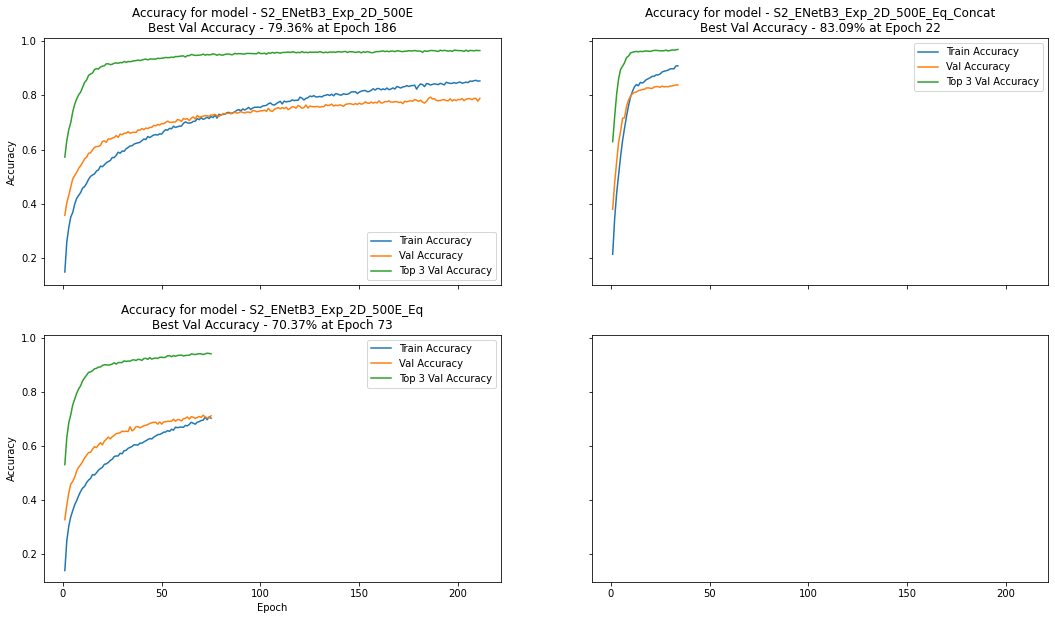

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.ravel()

for idx, model in enumerate(models.keys()):
    with open(f"{model_hist_path}{model}.pkl", 'rb') as file_pi:
        hist = pickle.load(file_pi)

    best_epoch = np.argmin(hist['val_loss'])

    metric_acc_key, metric_v_acc_key, metric_v_topk_acc_key = get_metric_keys(hist)

    sns.lineplot(x=range(1, len(hist[metric_acc_key]) + 1 ), y=hist[metric_acc_key], ax=axes[idx], label='Train Accuracy')
    sns.lineplot(x=range(1, len(hist[metric_v_acc_key]) + 1 ), y=hist[metric_v_acc_key], ax=axes[idx], label='Val Accuracy')
    sns.lineplot(x=range(1, len(hist[metric_v_topk_acc_key]) + 1 ), y=hist[metric_v_topk_acc_key], ax=axes[idx], label='Top 3 Val Accuracy')

    axes[idx].set(
        title=f"Accuracy for model - {model}\nBest Val Accuracy - {hist[metric_v_acc_key][best_epoch]:.2%} at Epoch {best_epoch+1}",
        xlabel="Epoch",
        ylabel="Accuracy"
    )

    # axes[idx].axvline(x=best_epoch+1, color='red')

# axes[3].axis('off')

plt.show()

In [ ]:
sel_model_name = 'S2_ENetB3_Exp_5D_500E'
sel_model = models[sel_model_name]

model = create_model(sel_model_name, sel_model, load_wts=True)


In [ ]:
images_test = generate_datasets(sel_model, df_test['image_paths'].values, labels=df_test['Category_Name_Code'].values)

for imgs, labels in images_val.take(1):
    break

In [ ]:
# get last convolutional layer of functional layer
last_conv_layer = [l.name for l in model.layers if 'conv' in l.name][-1]
last_conv_layer

'top_conv'

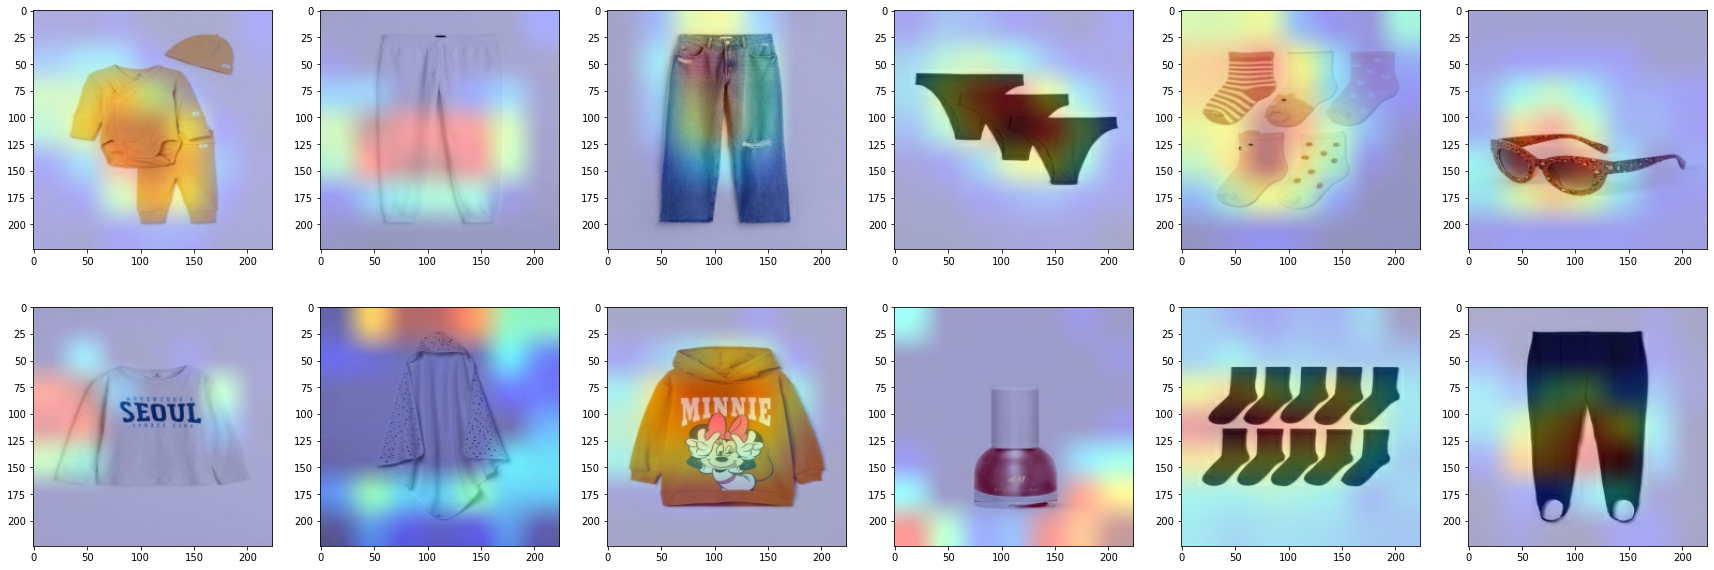

In [ ]:
fig, axes = plt.subplots(2, 6, figsize=(30, 10))
axes=axes.ravel()

for i in range(12):
    hm = make_gradcam_heatmap(np.expand_dims(imgs[i], axis=0), model, last_conv_layer)
    display_gradcam(imgs[i], hm, axes[i])

In [ ]:
# sel_model_name = 'Resnet50_Exp_2D_500E'
# sel_model = models[sel_model_name]

# model = create_model(sel_model_name, sel_model, load_wts=True)


In [ ]:
# # get last convolutional layer of functional layer
# last_conv_layer = [l.name for l in model.layers if 'conv' in l.name][-1]
# last_conv_layer

In [ ]:
# fig, axes = plt.subplots(2, 6, figsize=(30, 10))
# axes=axes.ravel()

# for i in range(12):
#     hm = make_gradcam_heatmap(np.expand_dims(imgs[i], axis=0), model, last_conv_layer)
#     display_gradcam(imgs[i], hm, axes[i])

### F1 Score per category

In [ ]:
cats = df[['Category_Name_Code', 'Category_Name']].drop_duplicates().sort_values(by='Category_Name_Code').reset_index(drop=True)
cats.head()

,Category_Name_Code,Category_Name
0,0,Baby_Accessoires
1,1,Baby_Kleidung
2,2,Kids_Accessoires
3,3,Kids_Kleidung
4,4,Kids_Outdoor


In [ ]:
cats['Cnt_Products'] = df.groupby('Category_Name_Code')['Code'].count()
cats.head()

,Category_Name_Code,Category_Name,Cnt_Products
0,0,Baby_Accessoires,123
1,1,Baby_Kleidung,1058
2,2,Kids_Accessoires,286
3,3,Kids_Kleidung,4237
4,4,Kids_Outdoor,268


In [ ]:
# get all y_true values
y_true = []
y_preds = []
for imgs, labels in images_val:
    y_true.extend(labels.numpy().tolist())
    preds = model.predict(imgs)
    y_preds.extend(np.argmax(preds, axis=1))

KeyboardInterrupt: ignored

In [ ]:
cats['F1_Score'] = f1_score(y_true, y_preds, average=None)

In [ ]:
cats[['Category_Name', 'Cnt_Products', 'F1_Score']]

,Category_Name,Cnt_Products,F1_Score
0,Baby_Accessoires,123,0.761905
1,Baby_Kleidung,1058,0.717850
2,Kids_Accessoires,286,0.566929
3,Kids_Kleidung,4237,0.790541
4,Kids_Outdoor,268,0.657143
5,Kids_Schuhe,198,0.685714
6,Men_Accessoires,271,0.059701
7,Men_Cardigans-&-Pullover,130,0.731707
8,Men_Hemden,160,0.555556
9,Men_Hoodies-&-Sweatshirts,143,0.793103


### Checking predictions on CnA Data

In [ ]:
# load the dataframe
df_cna = pd.read_parquet(cna_file_format.format('Final_Df_Test'))

In [ ]:
# get category codes
df_cna = df_cna.merge(cats[['Category_Name_Code', 'Category_Name']], how='left', left_on='Cat_Name_Mapped', right_on='Category_Name')

# get img filenames
df_cna['image_paths'] = df_cna.apply(lambda row: f"{cna_img_resized}{row['Code']}{row['Img_Ext']}", axis=1)

df_cna.head()

,Code,Name,URL,Img_URL,Img_Ext,Category,Parent_Category,Cat_Name_Mapped,Category_Name_Code,Category_Name,image_paths
0,2158240_1,CLOCKHOUSE - Kleid - kariert,https://www.c-and-a.com/de/de/shop/clockhouse-...,https://www.c-and-a.com/productimages/b_rgb:EB...,.jpg,75.0,2.0,Women_Kleider,22,Women_Kleider,/content/drive/MyDrive/Temporary/CS25_Project/...
1,2173987_2,CLOCKHOUSE - Kleid - geblümt,https://www.c-and-a.com/de/de/shop/clockhouse-...,https://www.c-and-a.com/productimages/b_rgb:EB...,.jpg,75.0,2.0,Women_Kleider,22,Women_Kleider,/content/drive/MyDrive/Temporary/CS25_Project/...
2,2165021_2,Strickkleid,https://www.c-and-a.com/de/de/shop/strickkleid...,https://www.c-and-a.com/productimages/b_rgb:EB...,.jpg,73.0,2.0,Women_Kleider,22,Women_Kleider,/content/drive/MyDrive/Temporary/CS25_Project/...
3,2155417_1,Kleid,https://www.c-and-a.com/de/de/shop/kleid-21554...,https://www.c-and-a.com/productimages/b_rgb:EB...,.jpg,81.0,2.0,Women_Kleider,22,Women_Kleider,/content/drive/MyDrive/Temporary/CS25_Project/...
4,2130669_1,Strickkleid,https://www.c-and-a.com/de/de/shop/strickkleid...,https://www.c-and-a.com/productimages/b_rgb:EB...,.jpg,73.0,2.0,Women_Kleider,22,Women_Kleider,/content/drive/MyDrive/Temporary/CS25_Project/...


In [ ]:
images_cna = generate_datasets(sel_model, df_cna['image_paths'].values, labels = df_cna['Category_Name_Code'].values)

In [ ]:
# get all y_true values
y_true = []
y_preds = []
for imgs, labels in images_cna:
    y_true.extend(labels.numpy().tolist())
    preds = model.predict(imgs)
    y_preds.extend(np.argmax(preds, axis=1))

In [ ]:
f1_score(y_true, y_preds, average=None)

array([0.        , 0.53146853, 0.11111111, 0.21086262, 0.        ,
       0.375     , 0.        , 0.38961039, 0.18045113, 0.34375   ,
       0.        , 0.        , 0.        , 0.30952381, 0.24      ,
       0.        , 0.4137931 , 0.61728395, 0.55223881, 0.52830189,
       0.03846154, 0.87755102, 0.        , 0.28148148, 0.05882353,
       0.2295082 , 0.07017544, 0.46632124])

In [ ]:
cats[['Category_Name', 'Cnt_Products', 'F1_Score', 'F1_Score_Test']]

KeyError: ignored

In [ ]:
for imgs, labels in images_cna:
    break

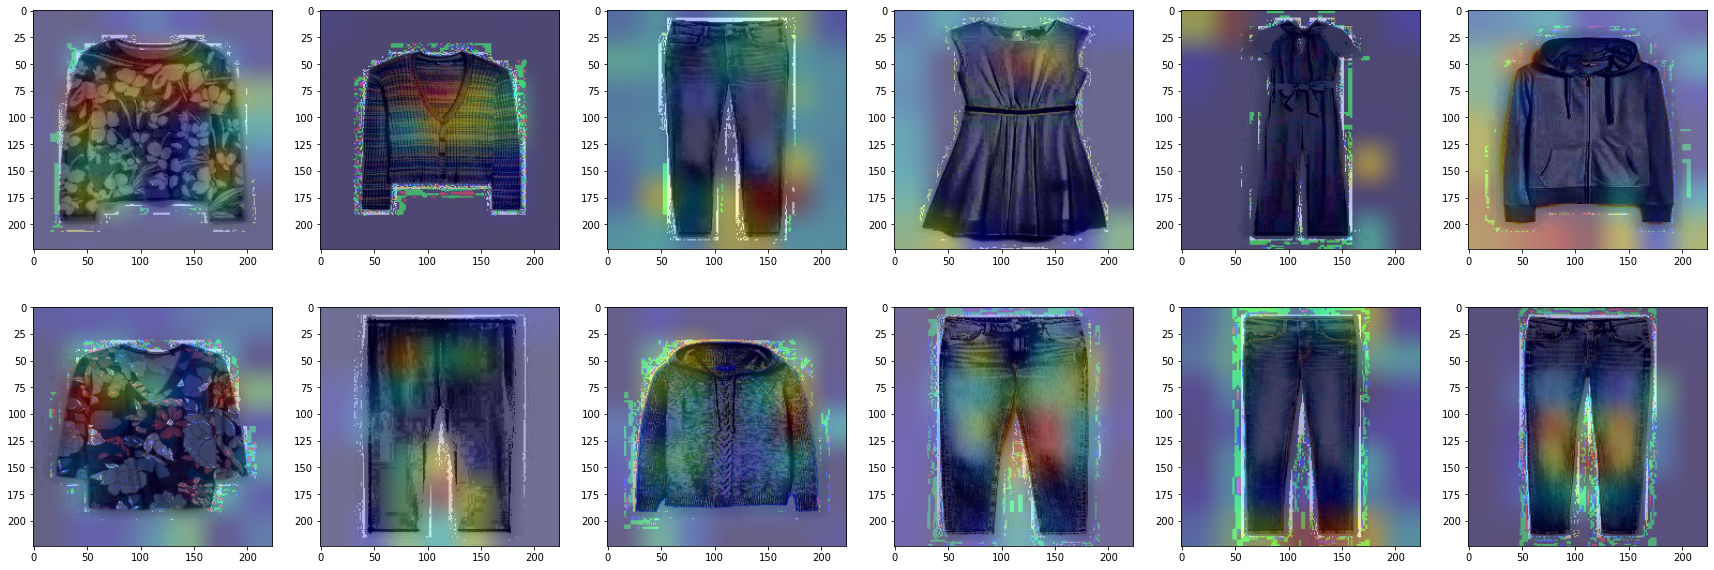

In [ ]:
fig, axes = plt.subplots(2, 6, figsize=(30, 10))
axes=axes.ravel()

for i in range(12):
    hm = make_gradcam_heatmap(np.expand_dims(imgs[i], axis=0), model, last_conv_layer)
    display_gradcam(imgs[i], hm, axes[i])

### Generating performance metrics

In [ ]:
def get_performance_metrics(y_true, y_pred, labels, plot_curves=True):
    """
        Helper function to get various performance metrics for all labels
        Returns:
            class_rep : The classification report as per sklearn's function
            conf_matrix: Multilabel confusion metrics
            fpr, tpr, thresholds: For ROC curve
            roc_auc: The AUC for each label
            f1_scores: the F1 scores for each 
    """
    # classification report
    y_pred = np.argmax(y_pred, axis=1)
    class_rep = classification_report(y_true, y_pred, target_names = labels, output_dict=True, zero_division=0)
    conf_matrix = multilabel_confusion_matrix(y_true, y_pred)

    # roc/auc
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()

    y_true_d = pd.get_dummies(y_true).values
    # prediction cols should match true cols
    exp_cols = pd.get_dummies(y_true).columns
    y_pred_d = pd.get_dummies(y_pred).reindex(columns=exp_cols, fill_value=0).values
    
    for i in range(len(labels)):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_true_d[:, i], y_pred_d[:, i])
        roc_auc[labels[i]] = auc(fpr[i], tpr[i])
        f1_scores[i] = f1_score(y_true_d[:, i], y_pred_d[:, i])
        
    if plot_curves:
        plot_roc_curves(labels, fpr, tpr, roc_auc)
        
    return {
        'class_rep': class_rep,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'roc_auc': roc_auc,
        'f1_scores': f1_scores
    }


In [ ]:
cp = get_performance_metrics(y_true, y_pred, list(cats['Category_Name'].values), plot_curves=False)

In [ ]:
cp.keys()

dict_keys(['class_rep', 'conf_matrix', 'fpr', 'tpr', 'thresholds', 'roc_auc', 'f1_scores'])

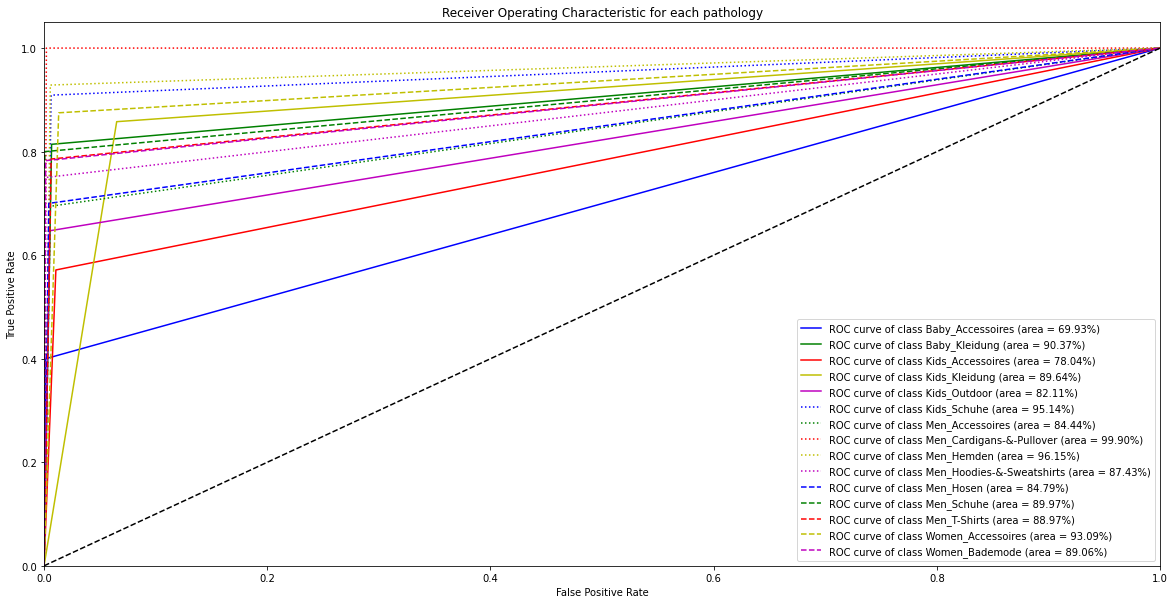

In [ ]:
plt.figure(figsize=(20, 10))

plot_roc_curves(list(cats['Category_Name'].values), cp['fpr'], cp['tpr'], cp['roc_auc'])

In [ ]:
def plot_roc_curves(labels, fpr, tpr, roc_auc):
    """
        Helper function to plot ROC Curve for each label class
    """
    # different line color/style for each label
    color = ['b-', 'g-', 'r-', 'y-', 'm-', 'b:', 'g:', 'r:', 'y:', 'm:', 'b--', 'g--', 'r--', 'y--', 'm--']
    
    for i, c in zip(range(len(labels)), color):
        plt.plot(
            fpr[i],
            tpr[i],
            c,
            label=f"ROC curve of class {labels[i]} (area = {roc_auc[labels[i]]:0.2%})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic for each pathology")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
np.unique(y_true)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=int8)

In [ ]:
pd.get_dummies(np.argmax(y_pred, axis=1)).reindex(columns=range(0, 31), fill_value=0)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1442,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1444,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
perf_metrics = {}
f1_scores = {}

for model_name, model_params in models.items():
    K.clear_session()
    filename = f"{model_hist_path}PerfMetrics_{model_name}.pkl"
    if os.path.exists(filename):
        # we've completed this one... let's keep going
        with open(filename, 'rb') as file_pi:
            perf_metrics[model_name] = pickle.load(file_pi)
        continue
    
    print(f"Starting for {model_name}")
    model = create_model(model_name, model_params, load_wts=True)

    print(f"Created model. Creating test set.")
    images_test = generate_datasets(model_params, df_test['image_paths'].values, labels = df_test['Category_Name_Code'].values, shuffle=False)
    
    y_true = df_test['Category_Name_Code'].values
    print(f"Making predictions")
    y_pred = model.predict(images_test)
    
    print(f"Calculating performance metrics")
    perf_metrics[model_name] = get_performance_metrics(y_true, y_pred, list(cats['Category_Name'].values), plot_curves=False)
    
    print(f"Completed for {model_name}")

    with open(filename, 'wb') as file_pi:
        pickle.dump(perf_metrics[model_name], file_pi)
    
    print(f"Saved for {model_name}")


Starting for S2_ENetB3_Exp_5D_500E
Created model. Creating test set.
Making predictions
Calculating performance metrics
Completed for S2_ENetB3_Exp_5D_500E
Saved for S2_ENetB3_Exp_5D_500E
Starting for S2_ENetB3_Exp_2D_500E_Eq_Concat
Created model. Creating test set.
Making predictions
Calculating performance metrics
Completed for S2_ENetB3_Exp_2D_500E_Eq_Concat
Saved for S2_ENetB3_Exp_2D_500E_Eq_Concat
Starting for S2_ENetB3_Exp_2D_500E_Eq
Created model. Creating test set.
Making predictions
Calculating performance metrics
Completed for S2_ENetB3_Exp_2D_500E_Eq
Saved for S2_ENetB3_Exp_2D_500E_Eq


### Training Filters model again

In [ ]:
df_filters = pd.read_parquet(hnm_file_format.format('Final_Input_Filters'))
with open('/content/drive/MyDrive/Temporary/CS25_Project/HnM_FilterValueLists.pkl', 'rb') as file_pi:
    filter_value_lists = pickle.load(file_pi)

In [ ]:
df_filters.head()

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Category_Filters,Product_Filters,Filter_Values
0,1071498001,Cut-out-Shirt,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1069183001,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1069183002,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1021919001,Pullover mit Cut-outs,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], ..."
4,1062813001,Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# generating a list of filter options
filter_options = [f[0].split('_')[0] for f in filter_value_lists]

### Cursory Checks on the Data

In [ ]:
df_filters.isna().sum()

Code                      0
Name                      0
Img_Ext                   0
Parent_Category           0
Top_Category              0
Parent_Category_Name      0
Category_Name             0
Category_Filters          0
Product_Filters         154
Filter_Values             0
dtype: int64

In [ ]:
# Dropping cols with null values
df_filters = df_filters.dropna().reset_index(drop=True)

In [ ]:
df_filters['Product_Filters'].apply(lambda x: len(x)).describe()

count    14302.0
mean        20.0
std          0.0
min         20.0
25%         20.0
50%         20.0
75%         20.0
max         20.0
Name: Product_Filters, dtype: float64

In [ ]:
(df_filters['Product_Filters'].apply(lambda x: len(x)) == len(filter_options)).value_counts()

True    14302
Name: Product_Filters, dtype: int64

Column Product Filters contains a binary list of applicable filters to that product. This can be used to switch on / off certain neurons depending on the categories

In [ ]:
# Checking that the length of the lists in filter values is also equal to 20
df_filters['Filter_Values'].apply(lambda x: len(x)).describe()

count    14302.0
mean        20.0
std          0.0
min         20.0
25%         20.0
50%         20.0
75%         20.0
max         20.0
Name: Filter_Values, dtype: float64

In [ ]:
# checking that we have filter values for all filter options i.e. the nr of lists within filter values with length > 0 should be the same as the sum of the Product Filters list
df_filters.apply(lambda row: (np.sum([(len(y) > 0)*1 for y in row['Filter_Values']]) == np.sum(row['Product_Filters'])), axis=1).value_counts()

True     14249
False       53
dtype: int64

In [ ]:
# found some unequal elements - exploring these further
uneq_ids = df_filters.apply(lambda row: (np.sum([(len(y) > 0)*1 for y in row['Filter_Values']]) == np.sum(row['Product_Filters'])), axis=1)

In [ ]:
print(df_filters[~uneq_ids].iloc[0]['Product_Filters'])
print(df_filters[~uneq_ids].iloc[0]['Filter_Values'])

[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0])
 array([], dtype=int64)
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0])
 array([], dtype=int64) array([], dtype=int64) array([], dtype=int64)
 array([], dtype=int64) array([], dtype=int64) array([], dtype=int64)
 array([], dtype=int64) array([], dtype=int64) array([], dtype=int64)
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# 53 values : dropping these for now to avoid confusion
df_filters = df_filters.drop(index=df_filters[~uneq_ids].index).reset_index(drop=True)

In [ ]:
df_filters.shape

(14249, 10)

In [ ]:
# adding a column with image paths in it
df_filters['image_paths'] = df_filters.apply(lambda row: f"{hnm_img_resized}{row['Code']}{row['Img_Ext']}", axis=1)
df_filters.head()

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Category_Filters,Product_Filters,Filter_Values,image_paths
0,1071498001,Cut-out-Shirt,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",/content/drive/MyDrive/Temporary/CS25_Project/...
1,1069183001,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",/content/drive/MyDrive/Temporary/CS25_Project/...
2,1069183002,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",/content/drive/MyDrive/Temporary/CS25_Project/...
3,1021919001,Pullover mit Cut-outs,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], ...",/content/drive/MyDrive/Temporary/CS25_Project/...
4,1062813001,Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",/content/drive/MyDrive/Temporary/CS25_Project/...


### Configuring some needed variables

In [ ]:
# load a display some sample images and then get it's shape since it'll needed in the model input

In [ ]:
img_shape = (224, 224, 3)

In [ ]:
# set up the output size for each of the different output layers - each would vary
all_lens = np.concatenate(df_filters['Filter_Values'].apply(lambda x: np.array([len(y) for y in x])).values).reshape(-1, 20)

In [ ]:
out_size = []
for i in range(all_lens.shape[1]):
    lens = all_lens[:, i]
    out_size.append(int(np.mean(lens[lens > 0])))

# out_size = [out_size[0]]
out_size

[43, 13, 18, 12, 4, 9, 8, 3, 10, 9, 9, 3, 19, 152, 21, 4, 5, 9, 111, 4]

Creating a column for each Filter Option

In [ ]:
col_names = [f'Filter_Values_{x}' for x in range(len(out_size))]
df_filters = df_filters.merge(pd.DataFrame(df_filters['Filter_Values'].tolist(), columns=col_names), left_index=True, right_index=True, how='left')

In [ ]:
# ensuring that all arrays in each column are of the same length
for i, size in enumerate(out_size):
    df_filters[col_names[i]] = df_filters[col_names[i]].apply(lambda x: x if len(x) == size else np.zeros(size))

In [ ]:
df_filters.isna().sum()

Code                    0
Name                    0
Img_Ext                 0
Parent_Category         0
Top_Category            0
Parent_Category_Name    0
Category_Name           0
Category_Filters        0
Product_Filters         0
Filter_Values           0
image_paths             0
Filter_Values_0         0
Filter_Values_1         0
Filter_Values_2         0
Filter_Values_3         0
Filter_Values_4         0
Filter_Values_5         0
Filter_Values_6         0
Filter_Values_7         0
Filter_Values_8         0
Filter_Values_9         0
Filter_Values_10        0
Filter_Values_11        0
Filter_Values_12        0
Filter_Values_13        0
Filter_Values_14        0
Filter_Values_15        0
Filter_Values_16        0
Filter_Values_17        0
Filter_Values_18        0
Filter_Values_19        0
dtype: int64

In [ ]:
# Clipping the values of the filters to 1 since we only need to do a binary prediction
for i in range(20):
    df_filters[f"Filter_Values_{i}"] = df_filters[f"Filter_Values_{i}"].apply(lambda x: list(np.clip(x, 0, 1)))

### Custom Layer for switching neurons on/off

In [ ]:
class SwitchSigmoidLayer(tf.keras.layers.Dense):
    
    def __init__(self, units, *args, **kwargs):
        self.units = units
        super().__init__(units, *args, **kwargs)
    
    # def build(self, input_shape):
    #     self.kernel = self.add_weight("kernel", shape=(int(input_shape[-1]),))
    
    def call(self, inputs, inputs_mask):
        # check inputs_mask - if this layer id is 0 in that, set kernel to 0
        # return super().call(inputs)
        return tf.multiply(tf.tile(inputs_mask, [1, self.units]), super().call(inputs))
        # return tf.cond(tf.equal(inputs_mask, 0), lambda: tf.zeros(self.units), lambda: super().call(inputs))
        # return tf.multiply(inputs, self.kernel)

### Custom callback function to print loss and accuracy

In [ ]:
class CombinedMetric(tf.keras.callbacks.Callback):
    def __init__(self, out_size):
        self.out_size = out_size
        self.epoch = 0
        super(CombinedMetric, self).__init__()

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.epoch += 1
        logs['accuracy'] =  sum([logs[f'Switch_{i}_accuracy'] for i in range(self.out_size)]) / self.out_size
        logs['val_accuracy'] =  sum([logs[f'val_Switch_{i}_accuracy'] for i in range(self.out_size)]) / self.out_size
        print(f"Epoch: {self.epoch}: Loss = {logs['loss']:.2f}; Accuracy = {logs['accuracy']:.2%}; Val Accuracy = {logs['val_accuracy']:.2%};")
        # else:
        #     print(f"Epoch: {self.epoch}: Loss = {logs['loss']:.2f}; Accuracy = {logs['accuracy']:.2%}")


In [ ]:
# separating a test set
df_filters_train, df_filters_test = train_test_split(df_filters, train_size=0.9, random_state=25)

In [ ]:
# keeping train and validation separate
df_filters_train, df_filters_val = train_test_split(df_filters_train, train_size=0.8, random_state=25)

In [ ]:
models = {
    'S3_ENetB3_Filters_2D_500E_Eq_Concat': {
        'model': 'EfficientNetB3',
        'preprocess': 'efficientnet',
        'model_pooling': 'max',
        'epochs': 50,
        'learning_rate': 1e-4,
        'dense_layers': 2,
        'patience': 5,
        'min_delta': 0.01,
        'equalize': True,
        'concat': True,
        'regularize': True,
        'batch_size': 64,
        'model_filters': True, # controls the output layer
    },
}

In [ ]:
len(out_size)

20

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_hists = {}


for model_name, model_params in models.items():
    K.clear_session()
    if os.path.exists(f"{model_hist_path}{model_name}.pkl"):
        with open(f"{model_hist_path}{model_name}.pkl", 'rb') as file_pi:
            model_hists[model_name] = pickle.load(file_pi)
        # we've completed this one... let's keep going
        print(f"Skipping {model_name} since this is already completed.")
        continue

    print(f"Starting training with {model_name}")
    model = create_model(model_name, model_params)
    # model.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(), metrics=[Accuracy])

    if model_params.get('model_filters', False):
        images_train_f = generate_datasets(
            model_params, 
            df_filters_train['image_paths'].values, 
            product_filters = df_filters_train['Product_Filters'].values, 
            filter_values = df_filters_train[col_names].values, 
            batch_size=model_params.get('batch_size', batch_size)
            )
        images_val_f = generate_datasets(
            model_params, 
            df_filters_val['image_paths'].values, 
            product_filters = df_filters_val['Product_Filters'].values, 
            filter_values = df_filters_val[col_names].values, 
            batch_size=model_params.get('batch_size', batch_size)
            )

    # images_train_f = ds_preprocess(images_train, model_params)
    # images_val_f = ds_preprocess(images_val, model_params)

    images_train_f = images_train_f.prefetch(1)
    images_val_f = images_val_f.prefetch(1)

    print(f"All ready! Starting fit!")
    # model.summary()
    
    lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

    hist = model.fit(
        images_train_f,
        epochs=model_params['epochs'], 
        batch_size=batch_size, 
        validation_data=images_val_f,
        verbose=True, 
        callbacks = [CombinedMetric(len(out_size)), es, lr]
    )
  
    model.save_weights(f"{model_wts_path}{model_name}.h5")
  
    min_loss_idx = np.argmin(hist.history['val_loss'])

    model_hists[model_name] = hist
    with open(f"{model_hist_path}{model_name}.pkl", 'wb') as file_pi:
        pickle.dump(hist.history, file_pi)

    print(f"Completed training of {model_name} with max validation accuracy: {hist.history['val_accuracy'][min_loss_idx]:.2%} at Epoch Nr {min_loss_idx+1}")


    model = create_model(model_params)
    # print(model.summary())


Starting training with S3_ENetB3_Filters_2D_500E_Eq_Concat
All ready! Starting fit!
Epoch 1/50
161/161 [==============================] - 3812s 23s/step - loss: 3.5833 - Switch_0_loss: 0.0324 - Switch_1_loss: 0.0515 - Switch_2_loss: 0.5741 - Switch_3_loss: 0.2220 - Switch_4_loss: 0.0126 - Switch_5_loss: 0.1303 - Switch_6_loss: 0.0178 - Switch_7_loss: 0.0332 - Switch_8_loss: 0.3614 - Switch_9_loss: 0.1606 - Switch_10_loss: 0.1697 - Switch_11_loss: 0.0096 - Switch_12_loss: 0.4045 - Switch_13_loss: 0.5592 - Switch_14_loss: 0.0309 - Switch_15_loss: 0.0082 - Switch_16_loss: 0.3173 - Switch_17_loss: 0.0218 - Switch_18_loss: 0.2425 - Switch_19_loss: 0.1550 - Switch_0_accuracy: 0.9602 - Switch_1_accuracy: 0.9300 - Switch_2_accuracy: 0.0609 - Switch_3_accuracy: 0.6556 - Switch_4_accuracy: 0.9895 - Switch_5_accuracy: 0.8475 - Switch_6_accuracy: 0.9840 - Switch_7_accuracy: 0.9745 - Switch_8_accuracy: 0.4646 - Switch_9_accuracy: 0.8162 - Switch_10_accuracy: 0.8235 - Switch_11_accuracy: 0.9925 - Sw

KeyboardInterrupt: ignored

In [ ]:
model_name

'S3_ENetB3_Filters_2D_500E_Eq_Concat'

In [ ]:
model.save_weights(f"{model_wts_path}{model_name}.h5")

hist = model.history

min_loss_idx = np.argmin(hist.history['val_loss'])

model_hists[model_name] = hist
with open(f"{model_hist_path}{model_name}.pkl", 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)


In [ ]:
filter_model_name = 'S3_ENetB3_Filters_2D_500E_Eq_Concat'
filter_model_params = models[filter_model_name]

filter_model = create_model(filter_model_name, filter_model_params, load_wts=True)

In [ ]:
f1_scores = {}
cnt_products = {}

for model_name, model_params in models.items():
    K.clear_session()
    filename = f"{model_hist_path}PerfMetrics_{model_name}.pkl"
    if os.path.exists(filename):
        # we've completed this one... let's keep going
        with open(filename, 'rb') as file_pi:
            perf_metrics = pickle.load(file_pi)
        continue
    
    y_true = df_filters_test[col_names].values
    print(f"Making predictions")
    y_pred = filter_model.predict(images_test)
    
    print(f"Calculating performance metrics")
    for i in range(len(out_size)):
        filter_option_name = filter_options[i]
        filter_option_labels = [f.split('_', 1)[1] for f in filter_value_lists[i]]

        idx = np.where(df_filters_test['Product_Filters'].apply(lambda x: x[i]) == 1)

        y_true_idx = np.concatenate(y_true[idx[0], i]).reshape(len(idx[0]), -1)
        y_pred_idx = ((y_pred[i][idx[0]] > 0.5) * 1)

        f1_scores[filter_option_name] = f1_score(y_true_idx, y_pred_idx, zero_division=0, average='weighted')
        cnt_products[filter_option_name] = len(idx[0])

    perf_metrics = {
        'Cnt_Products': cnt_products,
        'F1_Scores': f1_scores,
    }

    print(f"Completed for {model_name}")

    with open(filename, 'wb') as file_pi:
        pickle.dump(perf_metrics, file_pi)
    
    print(f"Saved for {model_name}")


Making predictions
Calculating performance metrics
Completed for S3_ENetB3_Filters_2D_500E_Eq_Concat
Saved for S3_ENetB3_Filters_2D_500E_Eq_Concat


In [ ]:
perf_metrics

{'Cnt_Products': {'Accessory Style': 64,
  'Collar': 115,
  'Color': 1420,
  'Concept': 554,
  'Finish': 18,
  'Fit': 234,
  'Function': 34,
  'Heel Height': 48,
  'Length': 877,
  'Neckline': 421,
  'Occasion': 460,
  'Opacity': 16,
  'Pattern': 996,
  'Product Type': 1377,
  'Shoe Style': 48,
  'Skin Tone': 15,
  'Sleeve Length': 678,
  'Sleeve Style': 37,
  'Style': 581,
  'Waist Height': 379},
 'F1_Scores': {'Accessory Style': 0.06428571428571428,
  'Collar': 0.3333141762452107,
  'Color': 0.2428392257824342,
  'Concept': 0.3093012163794512,
  'Finish': 0.8116883116883116,
  'Fit': 0.1426642295241593,
  'Function': 0.694017094017094,
  'Heel Height': 0.7550675675675675,
  'Length': 0.6035737333447987,
  'Neckline': 0.71758930836016,
  'Occasion': 0.8639299613325588,
  'Opacity': 0.9175824175824175,
  'Pattern': 0.692871397829546,
  'Product Type': 0.11811762322033026,
  'Shoe Style': 0.29555555555555557,
  'Skin Tone': 0.8338907469342254,
  'Sleeve Length': 0.9596817107104346,
  'S